# Post-stack inversion with proximal solvers - Hess model

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')
import collections

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import segyio

from scipy.signal import filtfilt
from scipy.linalg import solve
from scipy.sparse.linalg import lsqr
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap

from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *

from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *
from pyproximal.optimization.segmentation import *

In [2]:
os.environ['NUMBA_NUM_THREADS']

'4'

Hess model

In [3]:
f = segyio.open('/Users/matteoravasi/Desktop/Statoil/2020/Project/SegmentationPostStack/SegmentationPostStack/timodel_vp.segy', ignore_geometry=True)
v = segyio.collect(f.trace[:]).T
v = v[::4, ::4]

nt0, nx = v.shape
dt0 = 0.004
t0 = np.arange(nt0)*dt0
dx = 4
x = np.arange(nx)*dx

rho = 1.
m = np.log(v*rho)

Identify classes

In [4]:
collections.Counter(m.ravel())

Counter({8.517191: 17685,
         8.597111: 9266,
         8.75998: 13726,
         8.848076: 29275,
         9.008956: 32047,
         9.602381: 46604,
         9.104645: 27420,
         9.1667: 25333,
         9.2524395: 47930,
         8.961877: 577,
         9.321701: 40953,
         9.3824415: 48559})

In [5]:
allcl = np.unique(m)
cl = np.array(list(filter(lambda x: np.count_nonzero(m.ravel() == x) > 10000, allcl)))
ncl = len(cl)

In [6]:
len(allcl), ncl

(12, 10)

In [7]:
vcl_true = np.zeros_like(m)

for icl in range(ncl):
    vcl_true[m == cl[icl]] = icl

Add small variations with different correlation lenght per class

In [8]:
m1 = np.copy(m)
sigmas = [0.3, 0.4, 0.2, 0.8, 0.4, 0.2, .4, .4, .5, 2.]
smooths = [5, 10, 5, 20, 10, 5, 10, 10, 5, 30]
for icl, (sig, smooth) in enumerate(zip(sigmas, smooths)):
    n = np.random.normal(0, sig, m.shape)
    n = gaussian_filter(n, sigma=smooth)
    m1[m == cl[icl]] += n[m == cl[icl]]

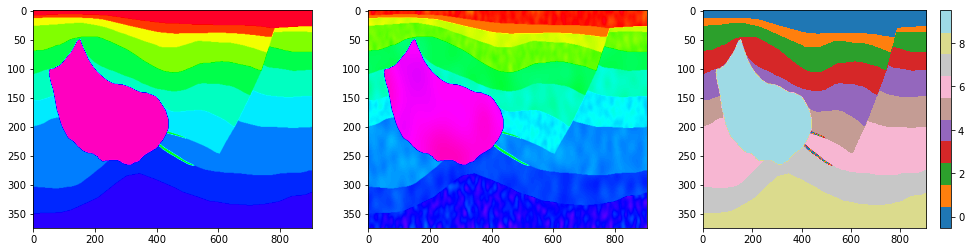

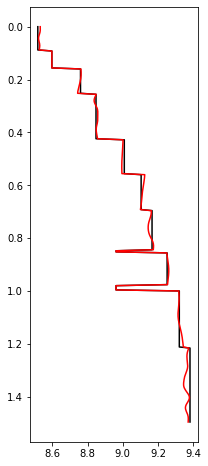

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(17, 4))
axs[0].imshow(m.reshape(nt0, nx), cmap='gist_rainbow')
axs[0].axis('tight')
axs[1].imshow(m1.reshape(nt0, nx), cmap='gist_rainbow')
axs[1].axis('tight');
im=axs[2].imshow(vcl_true.reshape(nt0, nx), cmap=cm.get_cmap('tab20', ncl), vmin=-0.5, vmax=ncl-0.5)
axs[2].axis('tight');
plt.colorbar(im);

plt.figure(figsize=(3, 8))
plt.plot(m[:, nx//2], t0, 'k')
plt.plot(m1[:, nx//2], t0, 'r')
plt.gca().invert_yaxis()

Use model with variations

In [10]:
m = m1.copy()

Compute data

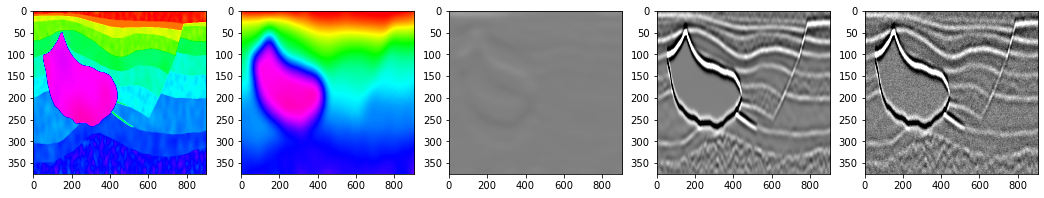

In [11]:
# smooth model
nsmooth = 50
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1,
                 filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m, axis=0), axis=1)

# wavelet
ntwav = 61
wav, twav, wavc = ricker(t0[:ntwav//2+1], 8)

# operator
Lop = PoststackLinearModelling(wav / 2, nt0=nt0, spatdims=nx)

# data
sigman=4e-2
d = Lop * m.ravel()
dn = d + np.random.normal(0, sigman, d.shape)

# background data
dback = Lop * mback.ravel()

d = d.reshape(nt0, nx)
dn = dn.reshape(nt0, nx)
dback = dback.reshape(nt0, nx)

fig, axs = plt.subplots(1, 5, figsize=(18, 3))
axs[0].imshow(m, cmap='gist_rainbow')
axs[0].axis('tight')
axs[1].imshow(mback, cmap='gist_rainbow')
axs[1].axis('tight')
axs[2].imshow(dback, cmap='gray', vmin=-0.1, vmax=0.1)
axs[2].axis('tight')
axs[3].imshow(d, cmap='gray', vmin=-0.1, vmax=0.1)
axs[3].axis('tight')
axs[4].imshow(dn, cmap='gray', vmin=-0.1, vmax=0.1)
axs[4].axis('tight');

## 2D Post-stack inversion

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 678750 rows and 339375 columns
damp = 1.00000000000000e-02   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       50
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.272e+01  3.272e+01    1.0e+00  2.6e-02
     1  5.39754e-02   2.521e+01  2.521e+01    7.7e-01  3.7e-01   1.3e+00  1.0e+00
     2  6.68174e-02   2.431e+01  2.431e+01    7.4e-01  1.6e-01   2.4e+00  2.3e+00
     3  7.65916e-02   2.390e+01  2.390e+01    7.3e-01  1.2e-01   3.4e+00  3.9e+00
     4  9.05329e-02   2.343e+01  2.343e+01    7.2e-01  6.2e-02   4.6e+00  6.5e+00
     5  9.51888e-02   2.327e+01  2.327e+01    7.1e-01  4.1e-02   5.4e+00  8.3e+00
     6  9.78801e-02   2.314e+01  2.314e+01    7.1e-01  3.3e-02   6.0e+00  1.0e+01
     7  9.78270e-02   2.304e+01  2.304e+01    7.0e-01  2.8e-02   6.7e+00  1.3e+01
     8  9.52551e-02   2.294e+0

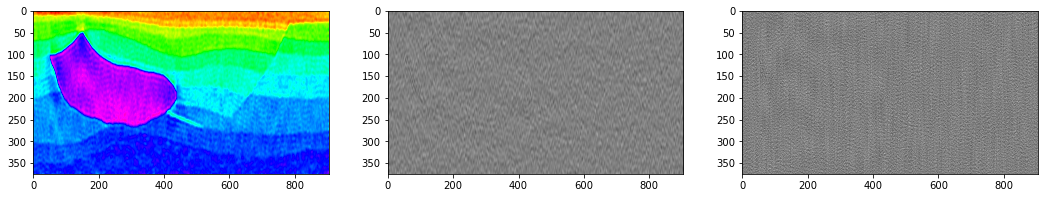

In [12]:
# L2 regularized inversion
Dop = Laplacian(dims=(nt0, nx), dtype=Lop.dtype)
minv = RegularizedInversion(Lop, [Dop], dn.ravel(),
                            x0=mback.ravel(), epsRs=[0.5], returninfo=False, show=True,
                            **dict(iter_lim=50, damp=1e-2))
dinv = Lop*minv

minv = minv.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

fig, axs = plt.subplots(1, 3, figsize=(18, 3))
axs[0].imshow(minv, cmap='gist_rainbow')
axs[0].axis('tight')
axs[1].imshow(d-dinv, cmap='gray', vmin=-0.1, vmax=0.1)
axs[1].axis('tight');
axs[2].imshow(dn-dinv, cmap='gray', vmin=-0.1, vmax=0.1)
axs[2].axis('tight');

SplitBregman (Blockiness-promoting inversion with anisotropic TV)
RegL1op = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='backward')
msb = SplitBregman(Lop, [RegL1op], dn.ravel(),
                   epsRL1s=[0.03], mu=0.2,
                   niter_outer=10,
                   niter_inner=4,
                   x0=mback.ravel(), show=True,
                   **dict(iter_lim=50, damp=1e-4))[0]
dinv = Lop*msb

msb = msb.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

fig, axs = plt.subplots(1, 3, figsize=(17, 3))
axs[0].imshow(msb, cmap='gist_rainbow')
axs[0].axis('tight')
axs[1].imshow(d-dinv, cmap='gray', vmin=-0.1, vmax=0.1)
axs[1].axis('tight');
axs[2].imshow(dn-dinv, cmap='gray', vmin=-0.1, vmax=0.1)
axs[2].axis('tight');

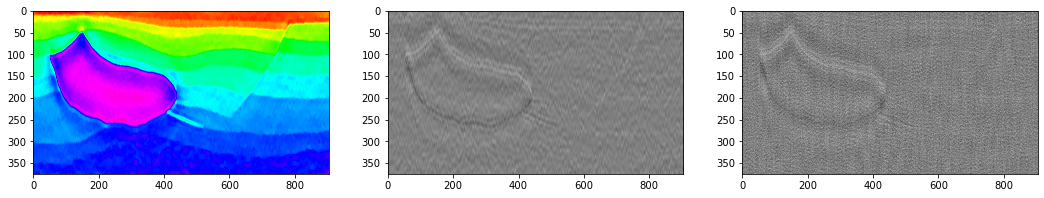

In [13]:
# L-ADMM (Blockiness-promoting inversion with isotropic TV)
Dop = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')

sigma=0.01
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=Lop, b=dn.ravel(), niter=10, warm=True)

# steps
L = 8. #np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 * tau / L # optimal mu<=tau/maxeig(Dop^H Dop)

mladmm = LinearizedADMM(l2, l1, Dop, tau=tau, mu=mu, x0=mback.ravel(), niter=100)[0]
dinv = Lop*mladmm

mladmm = mladmm.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

fig, axs = plt.subplots(1, 3, figsize=(18, 3))
axs[0].imshow(mladmm, cmap='gist_rainbow')
axs[0].axis('tight')
axs[1].imshow(d-dinv, cmap='gray', vmin=-0.1, vmax=0.1)
axs[1].axis('tight');
axs[2].imshow(dn-dinv, cmap='gray', vmin=-0.1, vmax=0.1)
axs[2].axis('tight');

Bregman
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Inner Solver: <function LinearizedADMM at 0x1a248bc0d0>
alpha = 2.000000e-01	tolf = 2.715000e+02	tolx = 1.000000e-10
niter = 10

   Itn       x[0]          f           g       J = f + g
     1   8.65358e+00   3.020e+02   2.165e+02   5.185e+02
     2   8.61353e+00   2.792e+02   2.570e+02   5.362e+02
     3   8.60693e+00   2.723e+02   2.862e+02   5.585e+02
     4   8.60382e+00   2.692e+02   3.046e+02   5.738e+02

Total time (s) = 317.25
---------------------------------------------------------



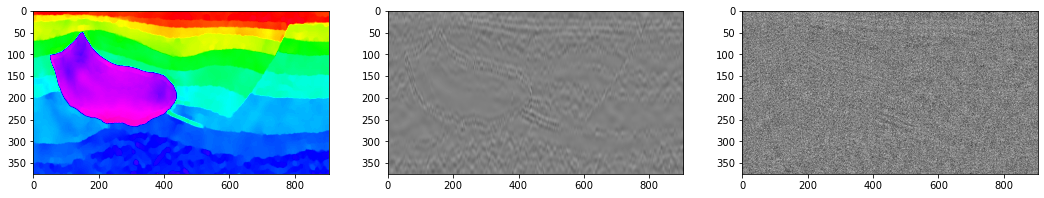

In [14]:
# Bregman with L-ADMM (Blockiness-promoting inversion with isotropic TV)
sigma = .2
l1 = L21(ndim=2)
l2 = L2(Op=Lop, b=dn.ravel(), niter=20, warm=True)
Dop = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')

# approach with norms of 2 operators (CHECK!)
#L1 = np.real((Lop.H*Lop).eigs(neigs=1, which='LM')[0])
#L = np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
#tau = 0.537669 #1. / L1 # optimal tau=1/maxeig(Lop^H Lop)
#mu = 0.0665 #0.99 * tau / L # optimal mu=tau/maxeig(Dop^H Dop)

# most common approach
L = 8 # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 * tau / L # optimal mu<=tau/maxeig(Dop^H Dop)

mb = Bregman(l2, l1, mback.ravel(), LinearizedADMM, 
             A=Dop, alpha=sigma,
             niterouter=10, 
             tolf=(dn.size * sigman ** 2) / 2.,# Morozov discrepancy
             show=True, **dict(tau=tau, mu=mu, niter=100))
dinv = Lop*mb

mb = mb.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

fig, axs = plt.subplots(1, 3, figsize=(18, 3))
axs[0].imshow(mb, cmap='gist_rainbow')
axs[0].axis('tight')
axs[1].imshow(d-dinv, cmap='gray', vmin=-0.1, vmax=0.1)
axs[1].axis('tight');
axs[2].imshow(dn-dinv, cmap='gray', vmin=-0.1, vmax=0.1)
axs[2].axis('tight');

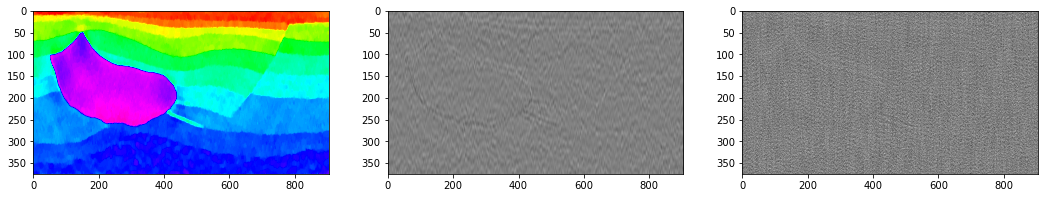

In [15]:
# Primal-dual (Blockiness-promoting inversion with isotropic TV)
sigma = 0.01
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=Lop, b=dn.ravel(), niter=20, warm=True)
Dop = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')

L = 8. # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 / (tau *L)

mpd = PrimalDual(l2, l1, Dop, mback.ravel(), tau=tau, mu=mu, theta=1., niter=100)
dinv = Lop*mpd

mpd = mpd.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

fig, axs = plt.subplots(1, 3, figsize=(18, 3))
axs[0].imshow(mpd, cmap='gist_rainbow')
axs[0].axis('tight')
axs[1].imshow(d-dinv, cmap='gray', vmin=-0.1, vmax=0.1)
axs[1].axis('tight');
axs[2].imshow(dn-dinv, cmap='gray', vmin=-0.1, vmax=0.1)
axs[2].axis('tight');

Bregman
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Inner Solver: <function PrimalDual at 0x1a248bc158>
alpha = 2.000000e-01	tolf = 2.715000e+02	tolx = 1.000000e-10
niter = 5

   Itn       x[0]          f           g       J = f + g
     1   8.73381e+00   3.006e+02   2.463e+02   5.468e+02
     2   8.68877e+00   2.745e+02   3.111e+02   5.856e+02
     3   8.67159e+00   2.708e+02   3.347e+02   6.055e+02

Total time (s) = 483.85
---------------------------------------------------------



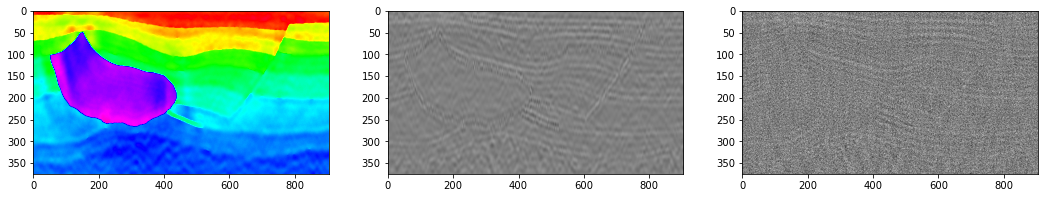

In [16]:
# Bregman with Primal-dual (Blockiness-promoting inversion with isotropic TV)
sigma = 0.2
l1 = L21(ndim=2)
l2 = L2(Op=Lop, b=dn.ravel(), niter=20, warm=True)
Dop = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')

L = 8 # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 / (tau *L)

mpdb = Bregman(l2, l1, mback.ravel(), PrimalDual, A=Dop, 
               niterouter=5, alpha=sigma, 
               tolf=(dn.size * sigman ** 2) / 2.,# Morozov discrepancy
               show=True, **dict(tau=tau, mu=mu, theta=1., niter=100))
dinv = Lop*mpdb

mpdb = mpdb.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

fig, axs = plt.subplots(1, 3, figsize=(18, 3))
axs[0].imshow(mpdb, cmap='gist_rainbow')
axs[0].axis('tight')
axs[1].imshow(d-dinv, cmap='gray', vmin=-0.1, vmax=0.1)
axs[1].axis('tight');
axs[2].imshow(dn-dinv, cmap='gray', vmin=-0.1, vmax=0.1)
axs[2].axis('tight');

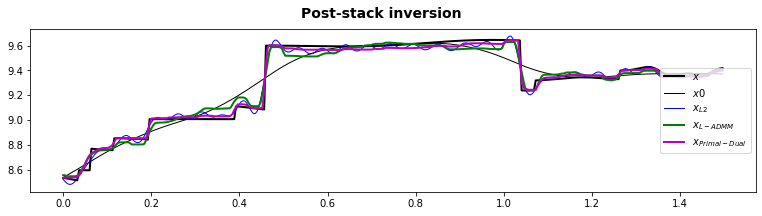

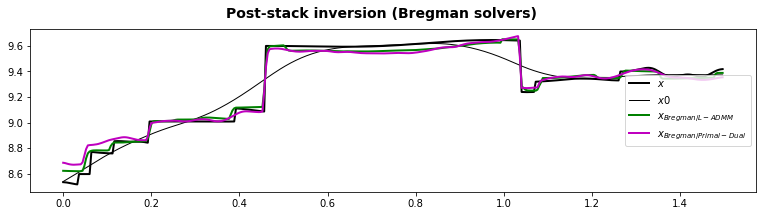

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(13, 3))
fig.suptitle('Post-stack inversion', fontsize=14, fontweight='bold')
ax.plot(t0, m[:, nx//4], 'k', lw=2, label=r'$x$')
ax.plot(t0, mback[:, nx//4], 'k', lw=1, label=r'$x0$')
ax.plot(t0, minv[:, nx//4], 'b', lw=1, label=r'$x_{L2}$')
ax.plot(t0, mladmm[:, nx//4], 'g', lw=2, label=r'$x_{L-ADMM}$')
ax.plot(t0, mpd[:, nx//4], 'm', lw=2, label=r'$x_{Primal-Dual}$')
ax.legend(loc='right');

fig, ax = plt.subplots(1, 1, figsize=(13, 3))
fig.suptitle('Post-stack inversion (Bregman solvers)', fontsize=14, fontweight='bold')
ax.plot(t0, m[:, nx//4], 'k', lw=2, label=r'$x$')
ax.plot(t0, mback[:, nx//4], 'k', lw=1, label=r'$x0$')
#ax.plot(t0, msb[:, nx//4], 'r', lw=2, label=r'$x_{Split-Bregman}$')
ax.plot(t0, mb[:, nx//4], 'g', lw=2, label=r'$x_{Bregman/L-ADMM}$')
ax.plot(t0, mpdb[:, nx//4], 'm', lw=2, label=r'$x_{Bregman/Primal-Dual}$')
ax.legend(loc='right');

## 2D Post-stack segmentation

Let's start by taking one of our previous inversion results and use it as input to a segmentation algorithm

In [22]:
segpd, segpd_classes = Segment(mpd, cl, 1., 0.01, niter=10, callback=None, simplex_engine='numba', show=False)

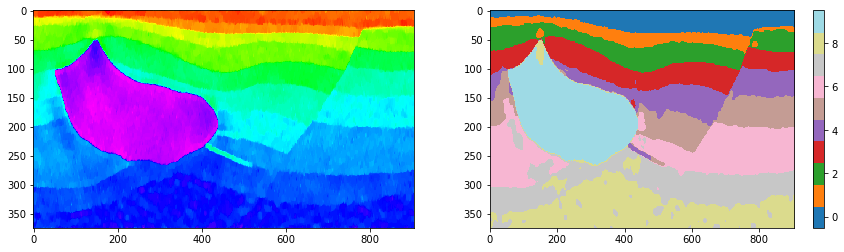

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].imshow(mpd, cmap='gist_rainbow')
axs[0].axis('tight')
im=axs[1].imshow(segpd_classes, cmap=cm.get_cmap('tab20', ncl), vmin=-0.5, vmax=ncl-0.5)
axs[1].axis('tight');
plt.colorbar(im);

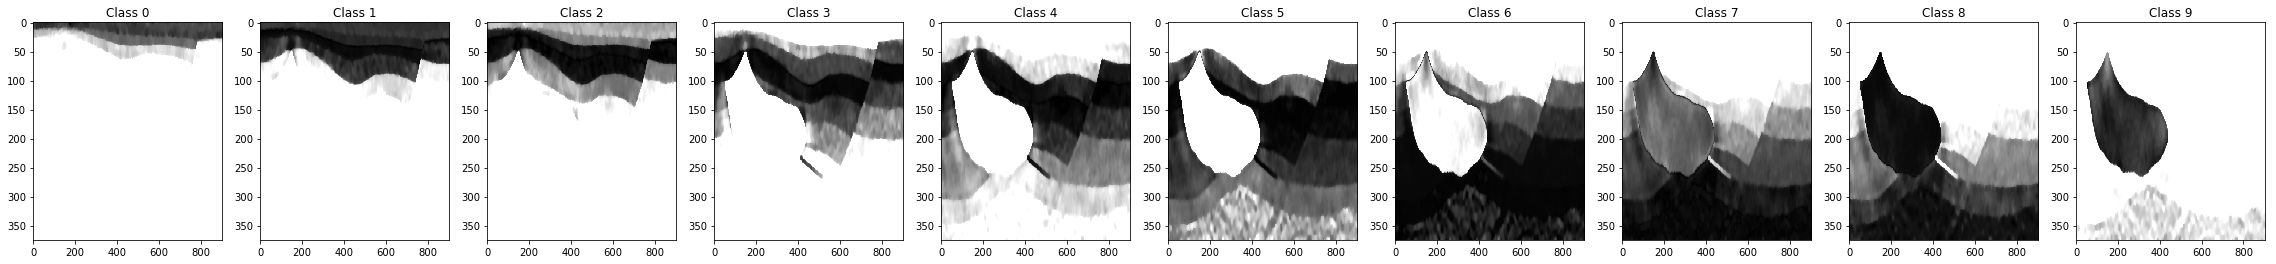

In [24]:
fig, axs = plt.subplots(1, ncl, figsize=(4*ncl, 4))
for icl in range(ncl):
    im = axs[icl].imshow(segpd[:, icl].reshape(nt0, nx), cmap='gray_r')
    axs[icl].set_title('Class %d' % icl)
    axs[icl].axis('tight')

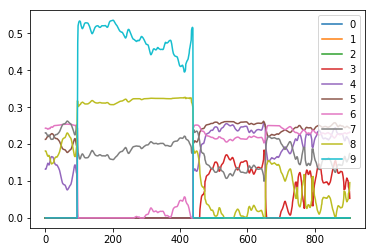

In [25]:
plt.figure()
for icl in range(ncl):
    plt.plot(segpd.reshape(nt0, nx, ncl)[200, :, icl], label=icl)
plt.legend()

In [26]:
np.savez('/Users/matteoravasi/Desktop/Poststack_segmentation/hess.npz', m=m, mpd=mpd, d=d,
         segpd_classes=segpd_classes, segpd=segpd, cl=cl)

## 2D Post-stack joint inversion & segmentation

**Inversion**

$$
m^{k+1} = min_x  (\frac{1}{2}||Ax-f||_2^2 + \delta ||\hat{V}x-\hat{c}||_2^2 - \alpha p^{kT}x) + \alpha ||Dx||_{2,1} 
$$

combining the first two terms

$$
m^{k+1} = min_x  (\frac{1}{2}||A^1x-f^1||_2^2 - \alpha p^{kT}x) + \alpha ||Dx||_{2,1} 
$$

where $A^1 = [A, \sqrt{2\delta}\hat{V}]^T$ and $f^1 = [f, \sqrt{2\delta}\hat{c}]^T$ and $\hat{V}=[diag(\sqrt{v_1}), ..., diag(\sqrt{v_N})]$ and $\hat{c}=[\sqrt{v_1}c_1, ..., \sqrt{v_N}c_N]$


**Segmentation**


$$
v^{k+1} = min_{v \in C}  (v^T(\delta g - \beta q^k) - \alpha p^{kT}x) + \alpha ||Dx||_{2,1} 
$$

where $C$ is a simplex.

Iteration 0...
f= 255.7998610597101
||v-v_old||_2= 441.9936280956574
||m-m_old||_2= 27.658681463592735
Iteration 1...
f= 286.77528379536824
||v-v_old||_2= 86.63183689183148
||m-m_old||_2= 14.929715548385934
Iteration 2...
f= 294.2734400862112
||v-v_old||_2= 56.10391289817257
||m-m_old||_2= 6.528154525249605
Iteration 3...
f= 292.23605469326594
||v-v_old||_2= 45.18067947465158
||m-m_old||_2= 3.462986138746578


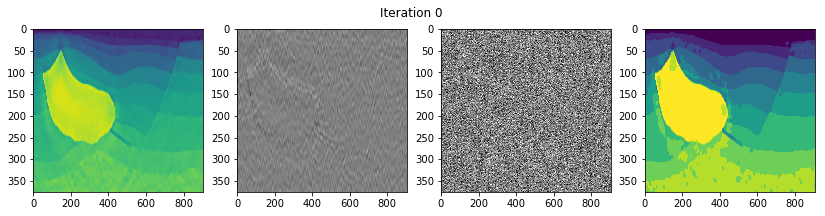

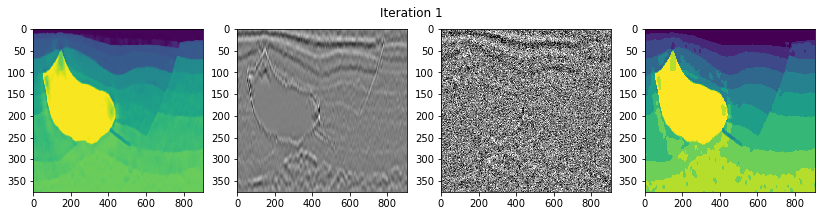

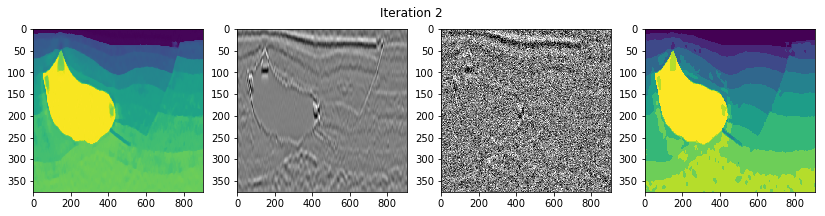

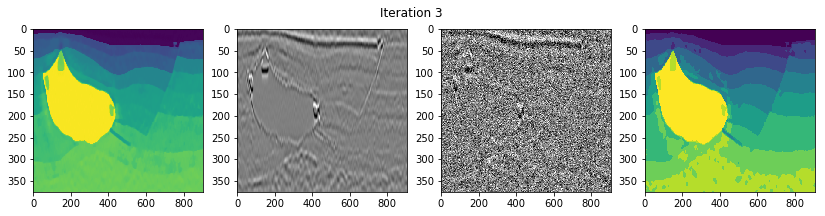

In [27]:
# regularization knobs

# QUITE GOOD!
#alpha=0.01
#beta=0.1
#delta = 10.

alpha=0.01
beta=5.
delta = 5.

niter = 4
tolstop = 0.

# TV regularization term
Dop = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')
l1_m = L21(ndim=2, sigma=alpha)

p = np.zeros_like(m).ravel()
q = np.zeros(ncl*m.size)
v = np.zeros(ncl*m.size)
minv = mback.copy().ravel()

for iiter in range(niter):
    print('Iteration %d...' % iiter)
    minvold = minv.copy()
    vold = v.copy()

    #############
    # Inversion #  
    #############
    if iiter == 0:
        # define misfit term
        l2 = L2(Op=Lop, b=dn.ravel(), niter=10, warm=True)

        # steps
        L = 8
        tau = .99 / np.sqrt(L)
        mu = .99 / np.sqrt(L)
            
        minv = PrimalDual(l2, l1_m, Dop, x0=mback.ravel(), tau=tau, mu=mu, theta=1., niter=100)
        minv = np.real(minv)
        dinv = Lop * minv

        # Update p
        l2_grad = L2(Op=Lop, b=dn.ravel())
        dp = (1./alpha) * l2_grad.grad(minv)
        p -= np.real(dp)      
    else:
        # define misfit term
        v = v.reshape((m.size, ncl))

        L1op = VStack([Lop] + [Diagonal(np.sqrt(2.*delta)*np.sqrt(v[:, icl])) for icl in range(ncl)])
        d1 = np.hstack([dn.ravel(), (np.sqrt(2.*delta)*(np.sqrt(v) * cl[np.newaxis, :]).T).ravel()])
        l2 = L2(Op=L1op, b=d1, niter=10, warm=True, q=p, alpha=-alpha)

        # steps
        L = 8.
        tau = .99 / np.sqrt(L)
        mu = .99 / np.sqrt(L)

        # solve
        minv = PrimalDual(l2, l1_m, Dop, x0=mback.ravel(), tau=tau, mu=mu, theta=1., niter=100)
        dinv = Lop * minv
        
        # Update p
        l2_grad = L2(Op=L1op, b=d1)
        dp = (1./alpha) * l2_grad.grad(minv)
        #dp = (1./alpha) * (Lop.H * (Lop * minv.ravel() - dn.ravel()) - 
        #                    2* delta * np.sum([v[:, icl] * (minv.ravel() - cl[icl]) 
        #                    for icl in range(ncl)]))
        p -= dp
     
    ################
    # Segmentation #  
    ################
    v, vcl = Segment(minv, cl, 2 * delta, 2 * beta, z=-beta*q, 
                     niter=10, simplex_engine='numba', callback=None, show=False)
    
    # Update q
    dq = (delta/beta) * ((minv.ravel() - cl[:, np.newaxis]) ** 2).ravel()
    q -= dq
    
    fig, axs = plt.subplots(1, 4, figsize=(14, 3))
    fig.suptitle('Iteration %d'% iiter)
    axs[0].imshow(minv.reshape(nt0, nx))
    axs[0].axis('tight')
    axs[1].imshow(d-dinv.reshape(nt0, nx), cmap='gray', vmin=-0.1, vmax=0.1)
    axs[1].axis('tight')
    axs[2].imshow(dn-dinv.reshape(nt0, nx), cmap='gray', vmin=-0.1, vmax=0.1)
    axs[2].axis('tight')
    axs[3].imshow(vcl.reshape(nt0, nx))
    axs[3].axis('tight')
    
    # Monitor cost functions
    print('f=', L2(Op=Lop, b=dn.ravel())(minv))
    print('||v-v_old||_2=', np.linalg.norm(v.ravel() - vold.ravel()))
    print('||m-m_old||_2=', np.linalg.norm(minv.ravel() - minvold.ravel()))

    # Check stopping criterion 
    if np.linalg.norm(v.ravel()-vold.ravel()) < tolstop:
        break

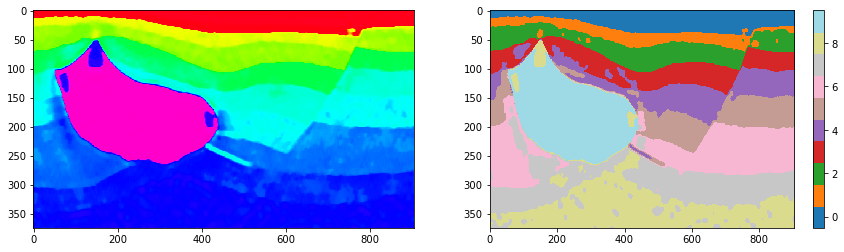

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].imshow(minv.reshape(nt0, nx), cmap='gist_rainbow')
axs[0].axis('tight')
im=axs[1].imshow(vcl.reshape(nt0, nx), cmap=cm.get_cmap('tab20', ncl), vmin=-0.5, vmax=ncl-0.5)
axs[1].axis('tight');
plt.colorbar(im);